# Create boundary conditions

In [2]:
import matplotlib.pyplot as plt
import netCDF4 as nc
import numpy as np
from mpl_toolkits.basemap import Basemap, cm
import cmocean
import pickle
import scipy.ndimage as ndimage

%matplotlib notebook

##### Parameters:

In [3]:
imin, imax = 1480, 2180
jmin, jmax = 160, 800

In [4]:
rimwidth_north = 10 # western Canada Basin
rimwidth_east  = 20 # northern Canada Basin
rimwidth_south = 10 # Baffin Bay

In [5]:
land_color = "#8b7765"

In [6]:
N_coordinates = ((2168, 2178, 201, 798))
E_coordinates = ((1481, 2178, 778, 798))

##### Functions:

In [7]:
def flatten_input(var):
    b = var[0,:,:].flatten()
    for i in range(1,len(var)):
        a = var[i,:,:].flatten()
        b = np.vstack((b,a))
    return b

In [8]:
def create_boundary(rimwidth, boundary_dMn, boundary_oMn):
    
    dMn_O = flatten_input(boundary_dMn)
    oMn_O = flatten_input(boundary_oMn)
    
    dMn_OBC = np.reshape(dMn_O, (1,50,1,np.max(boundary_dMn.shape)*rimwidth))
    oMn_OBC = np.reshape(oMn_O, (1,50,1,np.max(boundary_dMn.shape)*rimwidth))

    return dMn_OBC, oMn_OBC

In [9]:
def save_BC_file(name, dMn_BC, oMn_BC):
    # Setup the new NetCDF file:
    ncd = nc.Dataset('/ocean/brogalla/GEOTRACES/data/'+name, 'w', zlib=True)
    ncd.createDimension('x', np.max(dMn_BC.shape))
    ncd.createDimension('y',1)
    ncd.createDimension('z',50)
    ncd.createDimension('t',None)
    
    dMn = ncd.createVariable('dMn', 'float64', ('t','z','y','x'))
    dMn.units = 'dissolved Mn'
    dMn.long_name = 'dMn'
    dMn[:] = dMn_BC

    oMn = ncd.createVariable('oMn', 'float64', ('t','z','y','x'))
    oMn.units = 'oxidised Mn'
    oMn.long_name = 'oMn'
    oMn[:] = oMn_BC
    
    ncd.close()
    return

In [79]:
def create_BC(label, bdy_coordinates):
    
    (bdyimin, bdyimax, bdyjmin, bdyjmax) = bdy_coordinates
    
    # Load data from end of spin up period:
    #    Because the global model oMn concentrations are not correct for our region (much too low), 
    #    we use values for the boundary conditions from the end of the spin up period from our model run
    #    at 20 gridpoints interior from the boundary.
    inif = nc.Dataset('/data/brogalla/run_storage/Mn-set4-202004/ref-spin-up7/ANHA12_EXH006_2002_monthly.nc')
    
    if label=='N':
        ini_dMn = np.array(inif.variables['dissolmn'])[5,0,:,bdyimin-imin-10:bdyimax-10-imin,bdyjmin-jmin:bdyjmax-jmin]
        ini_oMn = np.array(inif.variables['oxidismn'])[5,0,:,bdyimin-imin-10:bdyimax-10-imin,bdyjmin-jmin:bdyjmax-jmin]

        dMn_bdy1 = np.copy(ini_dMn); oMn_bdy1 = np.copy(ini_oMn);
        
        # Mackenzie too high
        dMn_bdy1[0:15,:,0:240] = 2.5e-9
        oMn_bdy1[0:15,:,0:240] = 2.5e-9
        
#         # Articificial Alaskan Coastal Current
#         dMn_bdy1[3:15,:,240:275] = 8.5e-9
#         oMn_bdy1[3:15,:,240:275] = 2.5e-9
#         dMn_bdy1[3:15,:,240:295] = 8.5e-9
#         oMn_bdy1[3:15,:,240:295] = 2.5e-9
        
    elif label=='E':
        ini_dMn = np.array(inif.variables['dissolmn'])[5,0,:,bdyimin-imin:bdyimax-imin,bdyjmin-jmin-10:bdyjmax-jmin-10]
        ini_oMn = np.array(inif.variables['oxidismn'])[5,0,:,bdyimin-imin:bdyimax-imin,bdyjmin-jmin-10:bdyjmax-jmin-10]

        dMn_bdy1 = np.copy(ini_dMn); oMn_bdy1 = np.copy(ini_oMn);

        
    for z in range(0,50):
        # Replace zero values:
        dMn_bdy1[dMn_bdy1 == 0] = np.average(dMn_bdy1[z,:,:])
        oMn_bdy1[oMn_bdy1 == 0] = np.average(oMn_bdy1[z,:,:])

        # Replace ratios that are off:
        dMn_bdy1[(dMn_bdy1/oMn_bdy1) > 50] = np.average(dMn_bdy1[z,:,:])
        oMn_bdy1[(dMn_bdy1/oMn_bdy1) > 50] = np.average(oMn_bdy1[z,:,:])

    dMn_bdy1[(mbathy[:,bdyimin:bdyimax,bdyjmin:bdyjmax] < 0.1)] = 0.2e-9
    oMn_bdy1[(mbathy[:,bdyimin:bdyimax,bdyjmin:bdyjmax] < 0.1)] = 0.2e-9

    # Filter to smoothe out the forcing
    dMn_bdy = ndimage.gaussian_filter(dMn_bdy1, sigma=4, order=0)
    oMn_bdy = ndimage.gaussian_filter(oMn_bdy1, sigma=4, order=0)

    return dMn_bdy, oMn_bdy

In [11]:
def plot_boundary_transect(bdy, bdy_coordinates, layer, dMn_bdy, oMn_bdy):
    (bdyimin, bdyimax, bdyjmin, bdyjmax) = bdy_coordinates
    
    # Latitude of boundary:
    lats_bdy = lat_model[bdyimin:bdyimax,bdyjmin:bdyjmax]
    lons_bdy = lon_model[bdyimin:bdyimax,bdyjmin:bdyjmax]
    
    # Land mask data:
    if bdy=='N' or bdy=='S':
        mesh_bathy_bdy = mesh_bathy[bdyimin+layer,bdyjmin:bdyjmax]
        lats   = lats_bdy[layer,:]
        dMn    = dMn_bdy[:,layer,:]
        oMn    = oMn_bdy[:,layer,:]
    elif bdy=='E':
        lats = lons_bdy[:,layer]
        mesh_bathy_bdy = mesh_bathy[bdyimin:bdyimax,bdyjmin+layer]
        dMn    = dMn_bdy[:,:,layer]
        oMn    = oMn_bdy[:,:,layer]
    
    
    ### Figure:
    fig, ax = plt.subplots(2,2, figsize=(14,6))

    for axes in ax.flatten():
        axes.invert_yaxis()
        axes.plot(lats, mesh_bathy_bdy, c=land_color,zorder=2)
        axes.fill_between(lats, 4000, mesh_bathy_bdy, color=land_color, zorder=2)
        axes.set_xlabel('Degrees North')
        axes.set_ylabel('Depth')
        
    contour1 = ax[0,0].contourf(lats, mesh_depth, dMn*1e9, vmin=0, vmax=12, cmap=cmocean.cm.dense, zorder=1)
    ax[1,0].contourf(lats, mesh_depth, dMn*1e9, vmin=0, vmax=12, cmap=cmocean.cm.dense, zorder=1)
    contour2 = ax[0,1].contourf(lats, mesh_depth, oMn*1e9, vmin=0, vmax=5, cmap=cmocean.cm.dense, zorder=1)
    ax[1,1].contourf(lats, mesh_depth, oMn*1e9, vmin=0, vmax=5,  cmap=cmocean.cm.dense, zorder=1)

    if bdy=='N':
        ax[0,0].set_xlim(68, 75);   ax[0,1].set_xlim(68, 75);
        ax[0,0].set_ylim(4000, 0);  ax[0,1].set_ylim(4000, 0)
        ax[1,0].set_xlim(68.5, 72); ax[1,1].set_xlim(68.5, 72);
        ax[1,0].set_ylim(400, 0);   ax[1,1].set_ylim(400, 0);
    elif bdy=='E':
        ax[0,0].set_ylim(4000, 0);  ax[0,1].set_ylim(4000, 0)
        ax[1,0].set_ylim(400, 0);   ax[1,1].set_ylim(400, 0);
    ax[0,0].set_title("Dissolved Mn")
    ax[0,1].set_title("Oxidised Mn")
    
    cbar_ax1 = fig.add_axes([0.15, 0.56, 0.03, 0.26])
    cbar_ax2 = fig.add_axes([0.55, 0.56, 0.03, 0.26])
    cbar1 = fig.colorbar(contour1, cax=cbar_ax1)
    cbar2 = fig.colorbar(contour2, cax=cbar_ax2)
    cbar_ax1.tick_params(axis='both', which='major', labelsize=8)
    cbar_ax2.tick_params(axis='both', which='major', labelsize=8)
    return

##### Load files:

In [12]:
ref       = nc.Dataset('/data/brogalla/ANHA12/ANHA12-EXH006_5d_gridT_y2015m01d05.nc',  'r')
lat_model = np.array(ref.variables['nav_lat'])
lon_model = np.array(ref.variables['nav_lon'])

In [13]:
mesh       = nc.Dataset('/data/brogalla/old/meshmasks/ANHA12_mesh1.nc')
mesh_lon   = np.array(mesh.variables['nav_lon'])
mesh_lat   = np.array(mesh.variables['nav_lat'])
mesh_bathy = np.array(mesh.variables['hdept'])[0,:,:]
mbathy     = np.array(mesh.variables['tmask'])[0,:,:]
mesh_depth = np.array(mesh.variables['nav_lev'])

In [39]:
Nmn = nc.Dataset('/ocean/brogalla/GEOTRACES/data/Mn_North_OBC_20200327.nc')
dMn_north_old = np.reshape(np.array(Nmn.variables['dMn'])[0,:,0,:], (50,10,597))
oMn_north_old = np.reshape(np.array(Nmn.variables['oMn'])[0,:,0,:], (50,10,597))

In [43]:
Emn = nc.Dataset('/ocean/brogalla/GEOTRACES/data/Mn_East_OBC_20200102.nc')
dMn_east_old = np.reshape(np.array(Emn.variables['dMn'])[0,:,0,:], (50,697,20))
oMn_east_old = np.reshape(np.array(Emn.variables['oMn'])[0,:,0,:], (50,697,20))

##### Calculations and Figures:

In [80]:
dMn_north, oMn_north = create_BC('N', N_coordinates)

In [81]:
dMn_east, oMn_east = create_BC('E', E_coordinates)

<IPython.core.display.Javascript object>


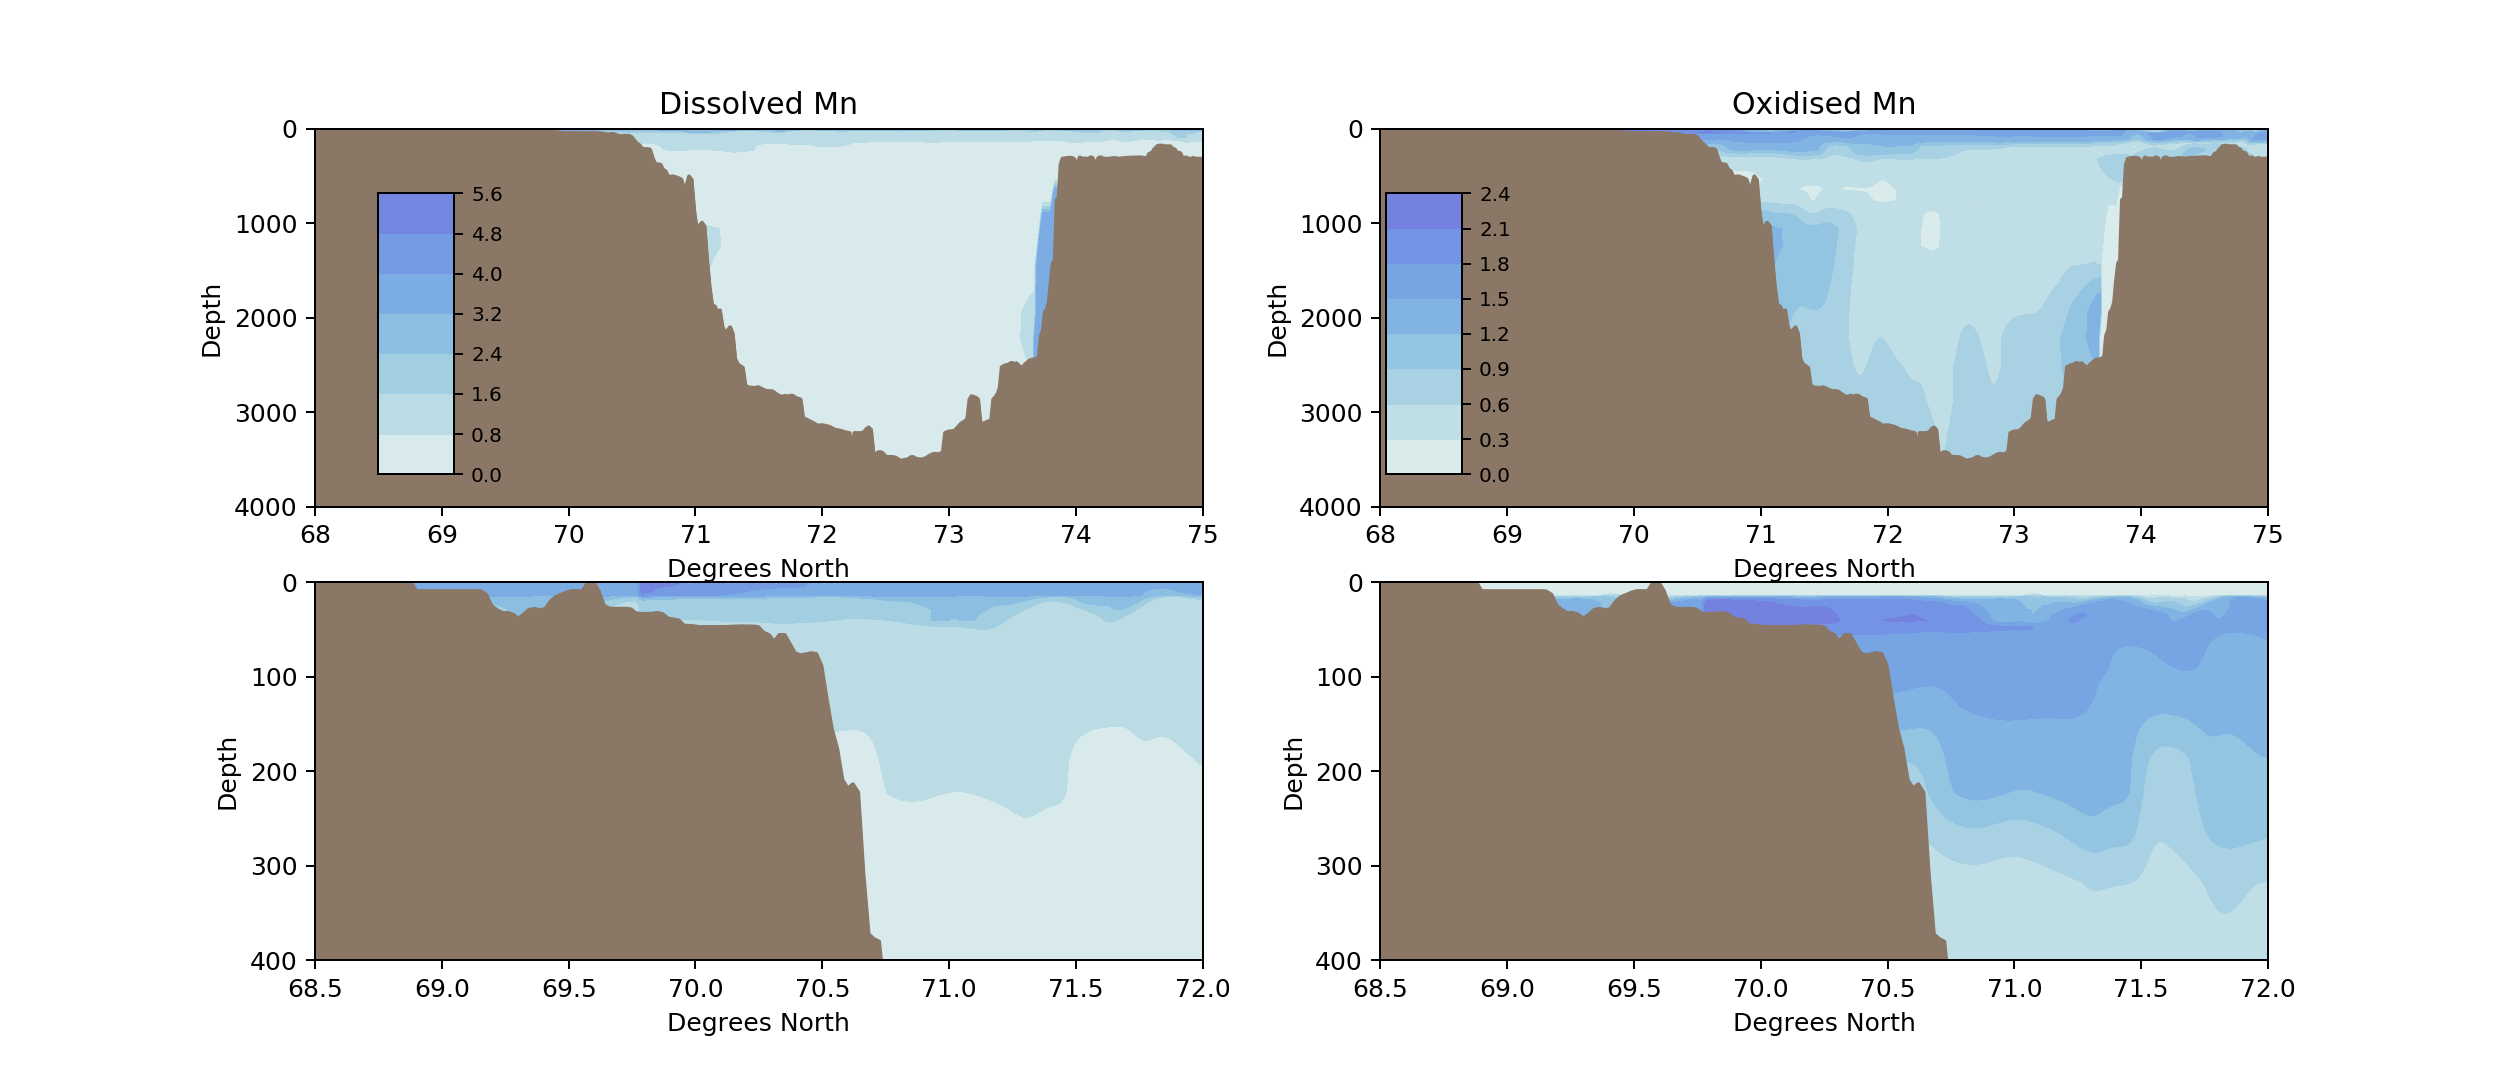

In [41]:
plot_boundary_transect('N', N_coordinates, 1, dMn_north_old, oMn_north_old)

<IPython.core.display.Javascript object>


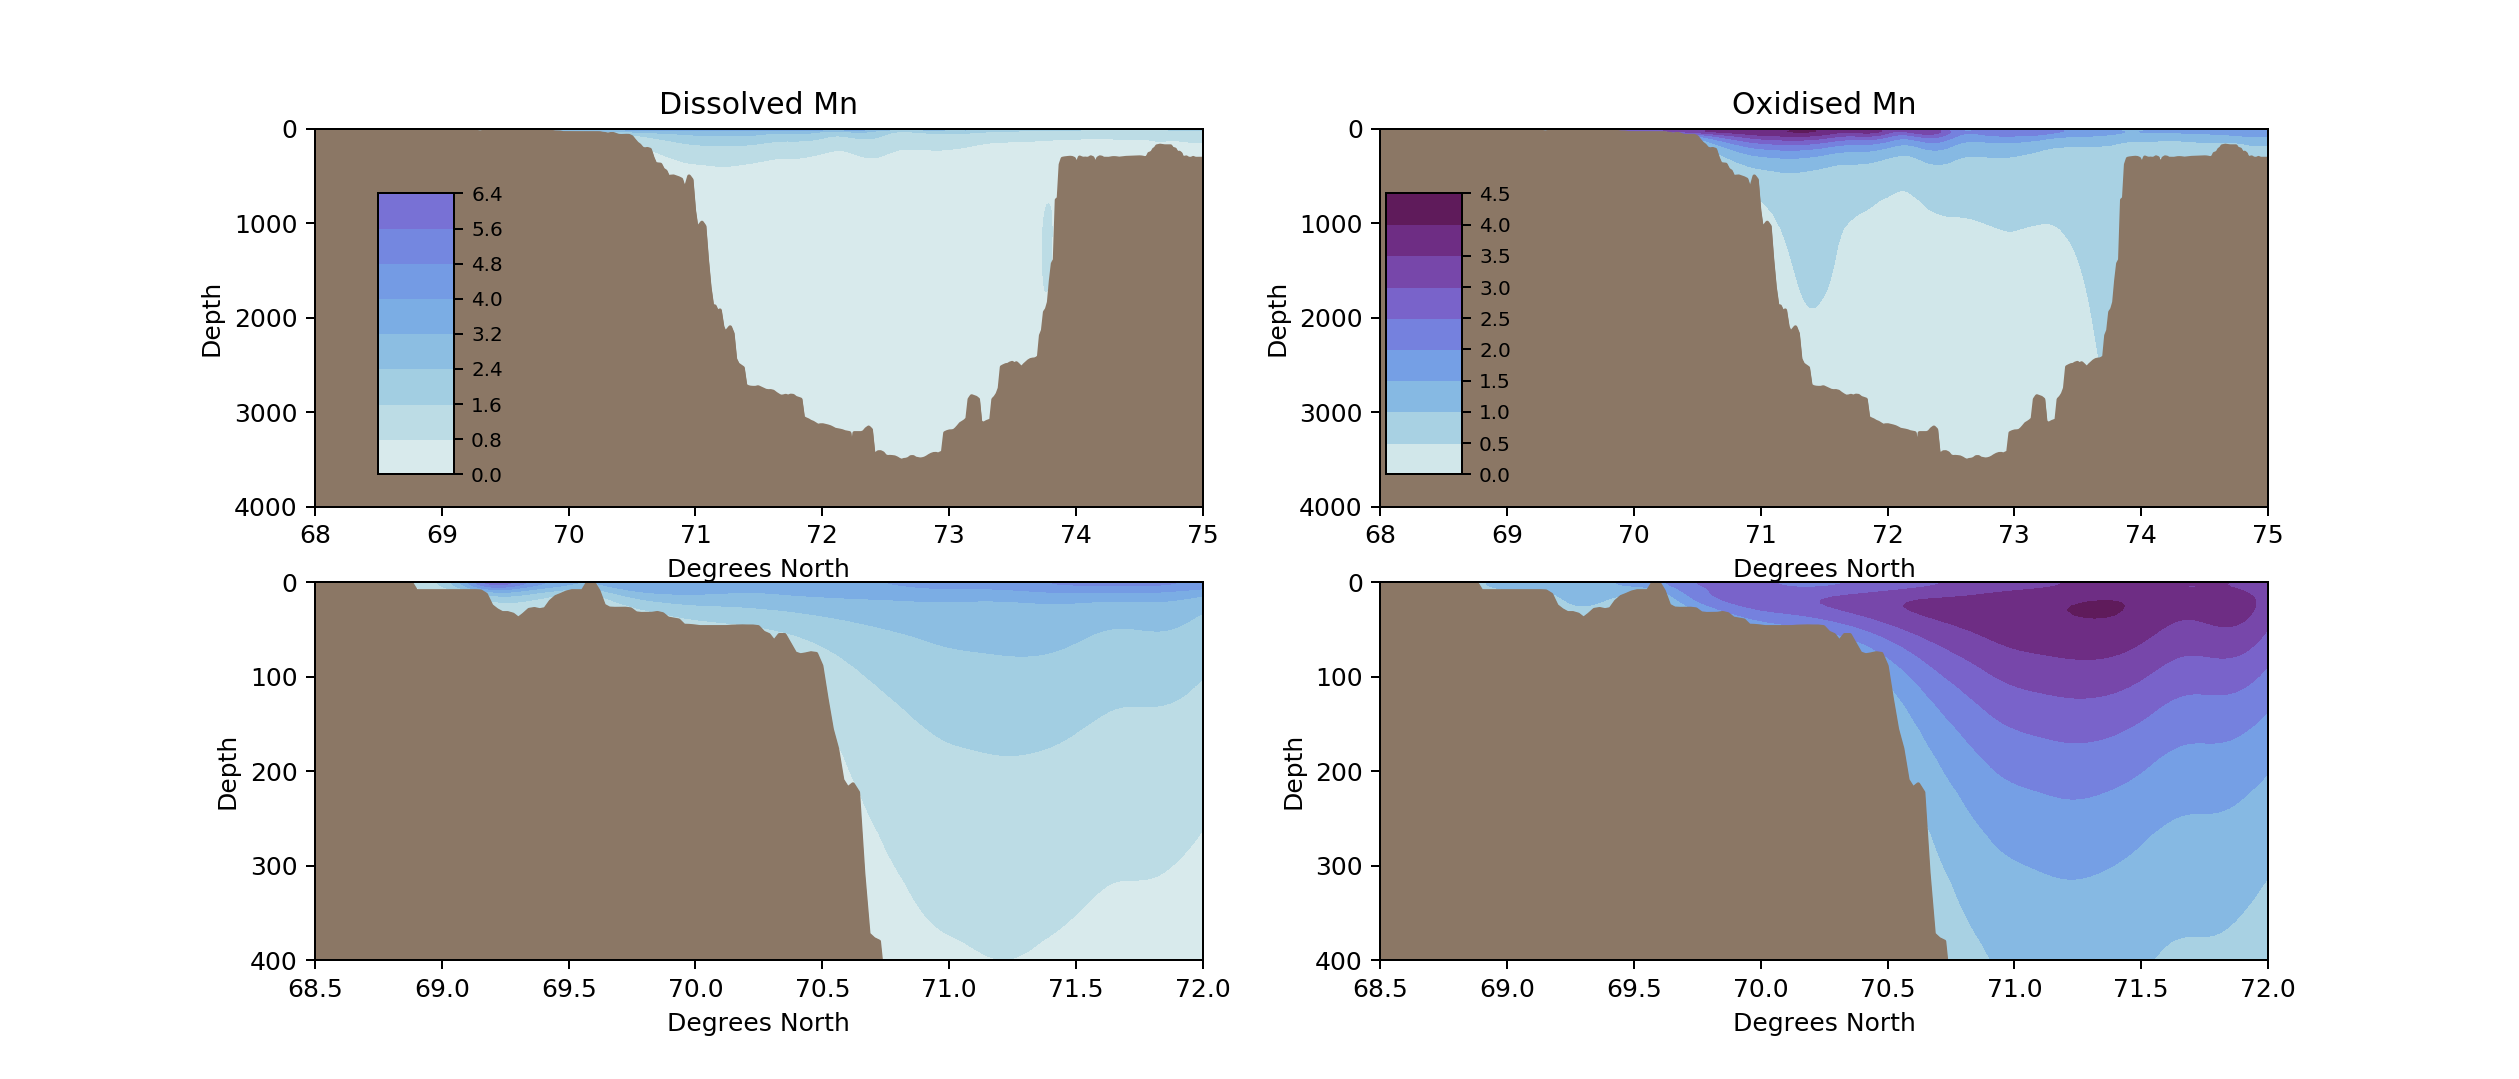

In [82]:
plot_boundary_transect('N', N_coordinates, 1, dMn_north, oMn_north)

<IPython.core.display.Javascript object>


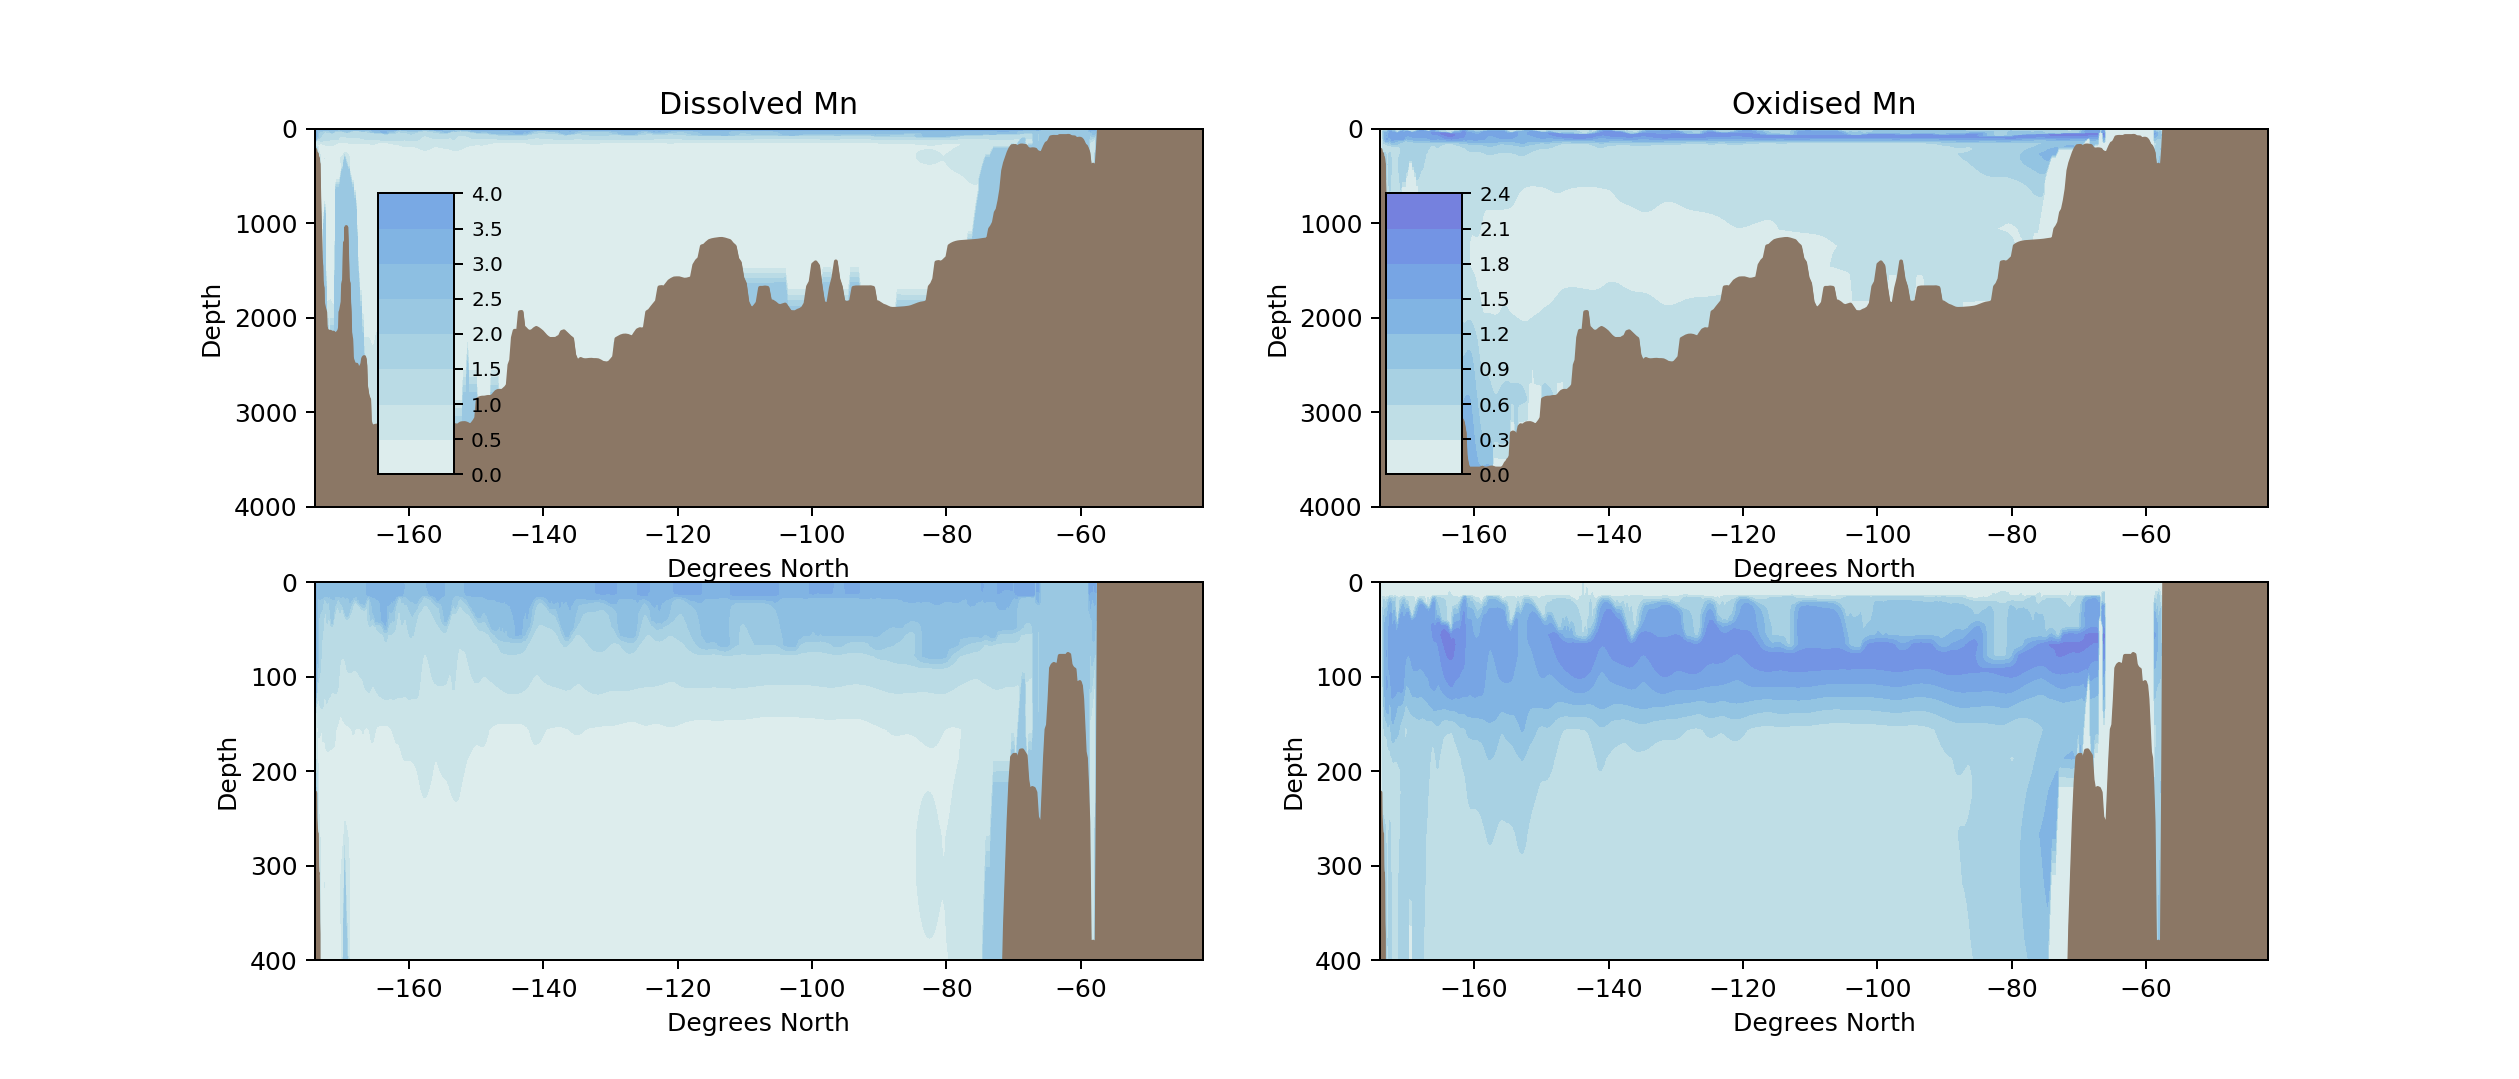

In [44]:
plot_boundary_transect('E', E_coordinates, 1, dMn_east_old, oMn_east_old)

<IPython.core.display.Javascript object>


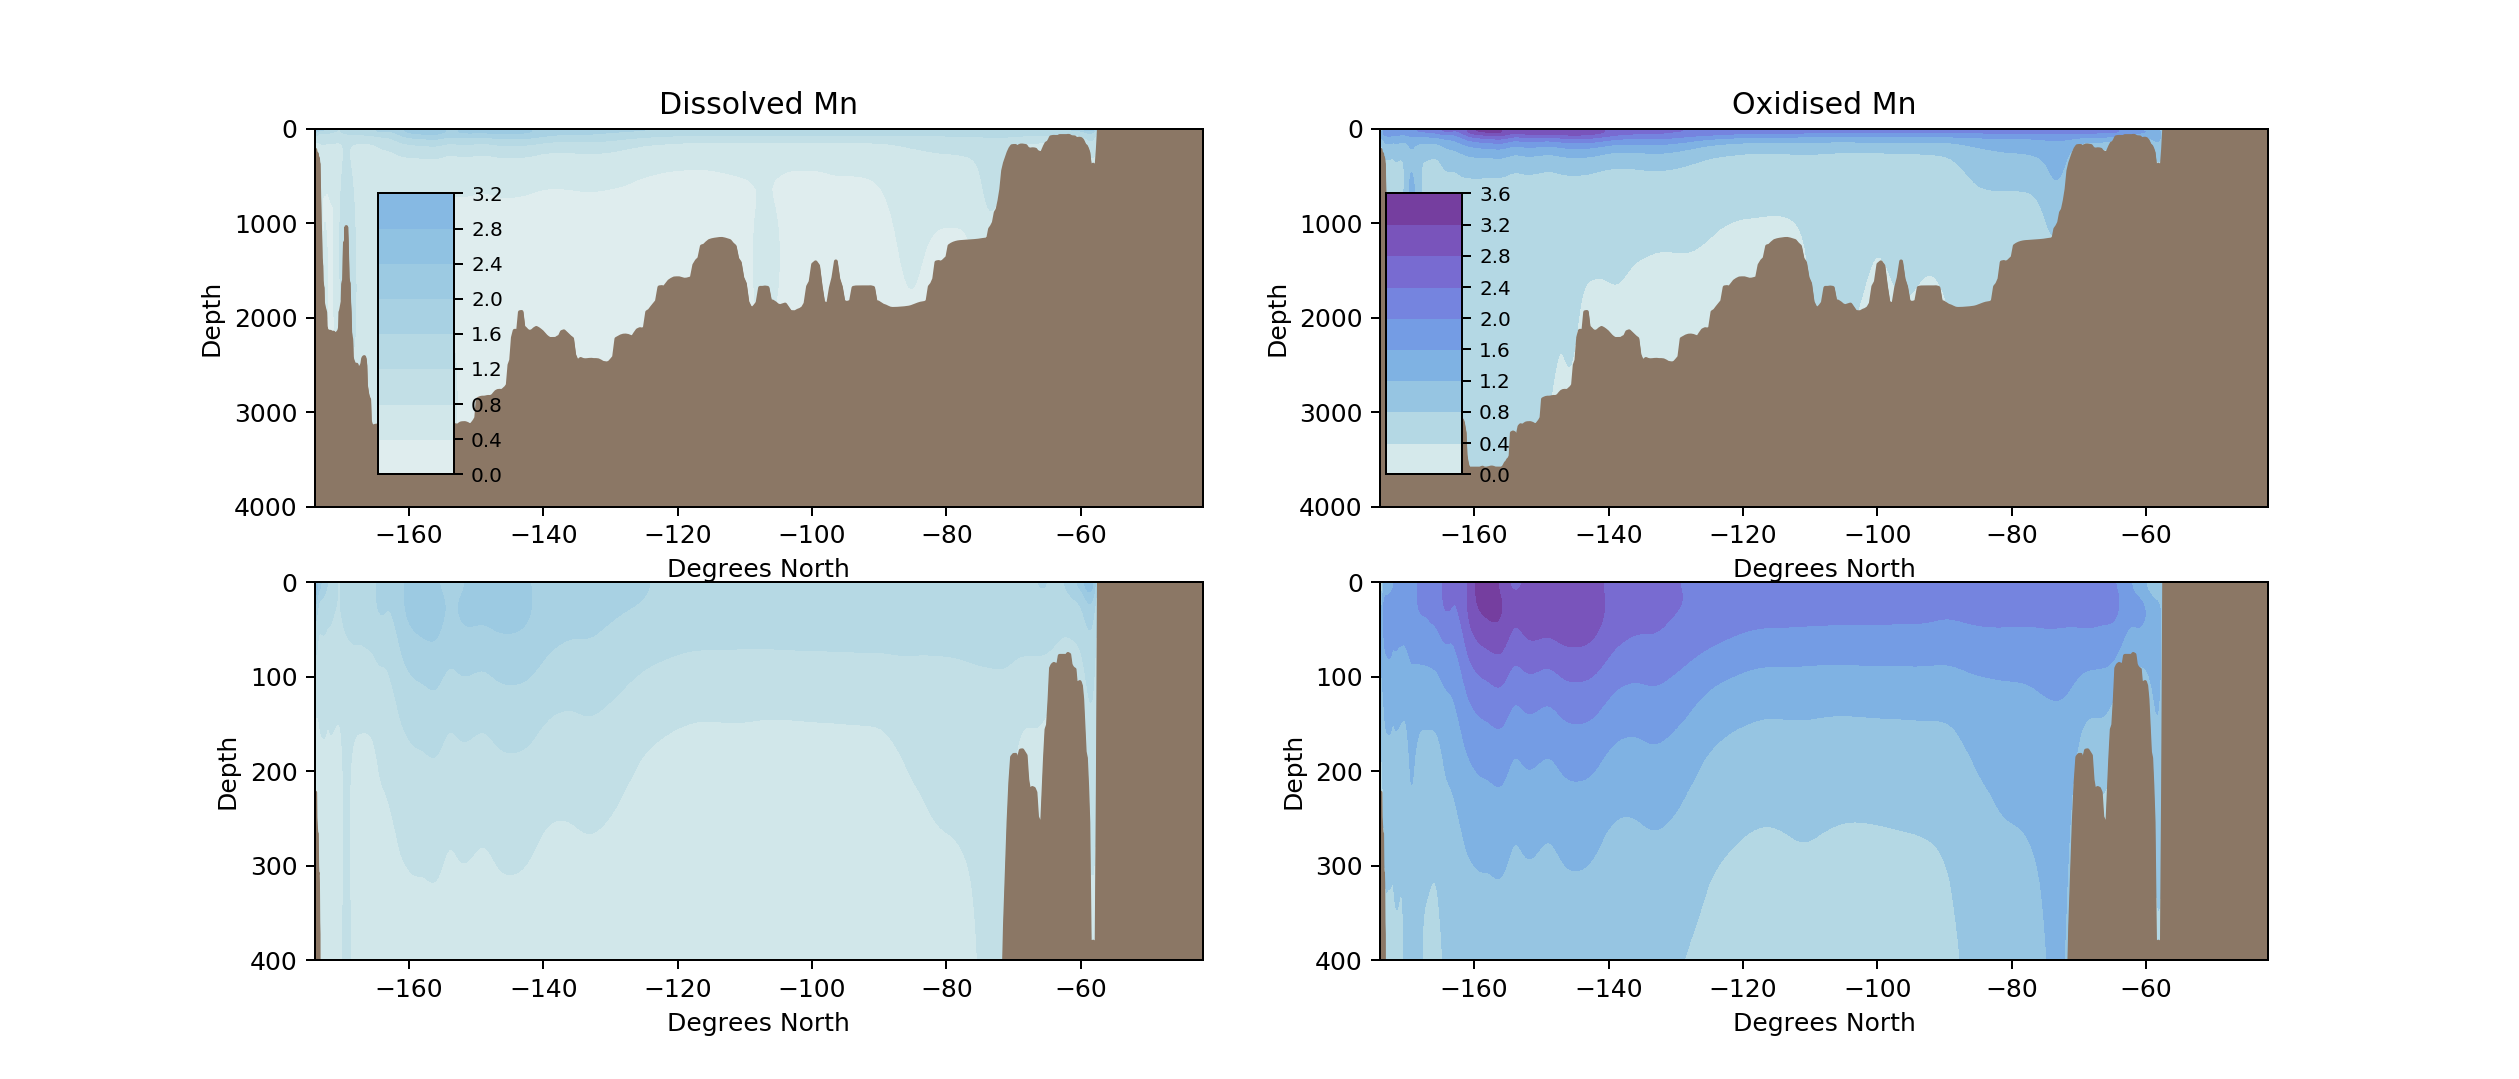

In [83]:
plot_boundary_transect('E', E_coordinates, 1, dMn_east, oMn_east)

<IPython.core.display.Javascript object>


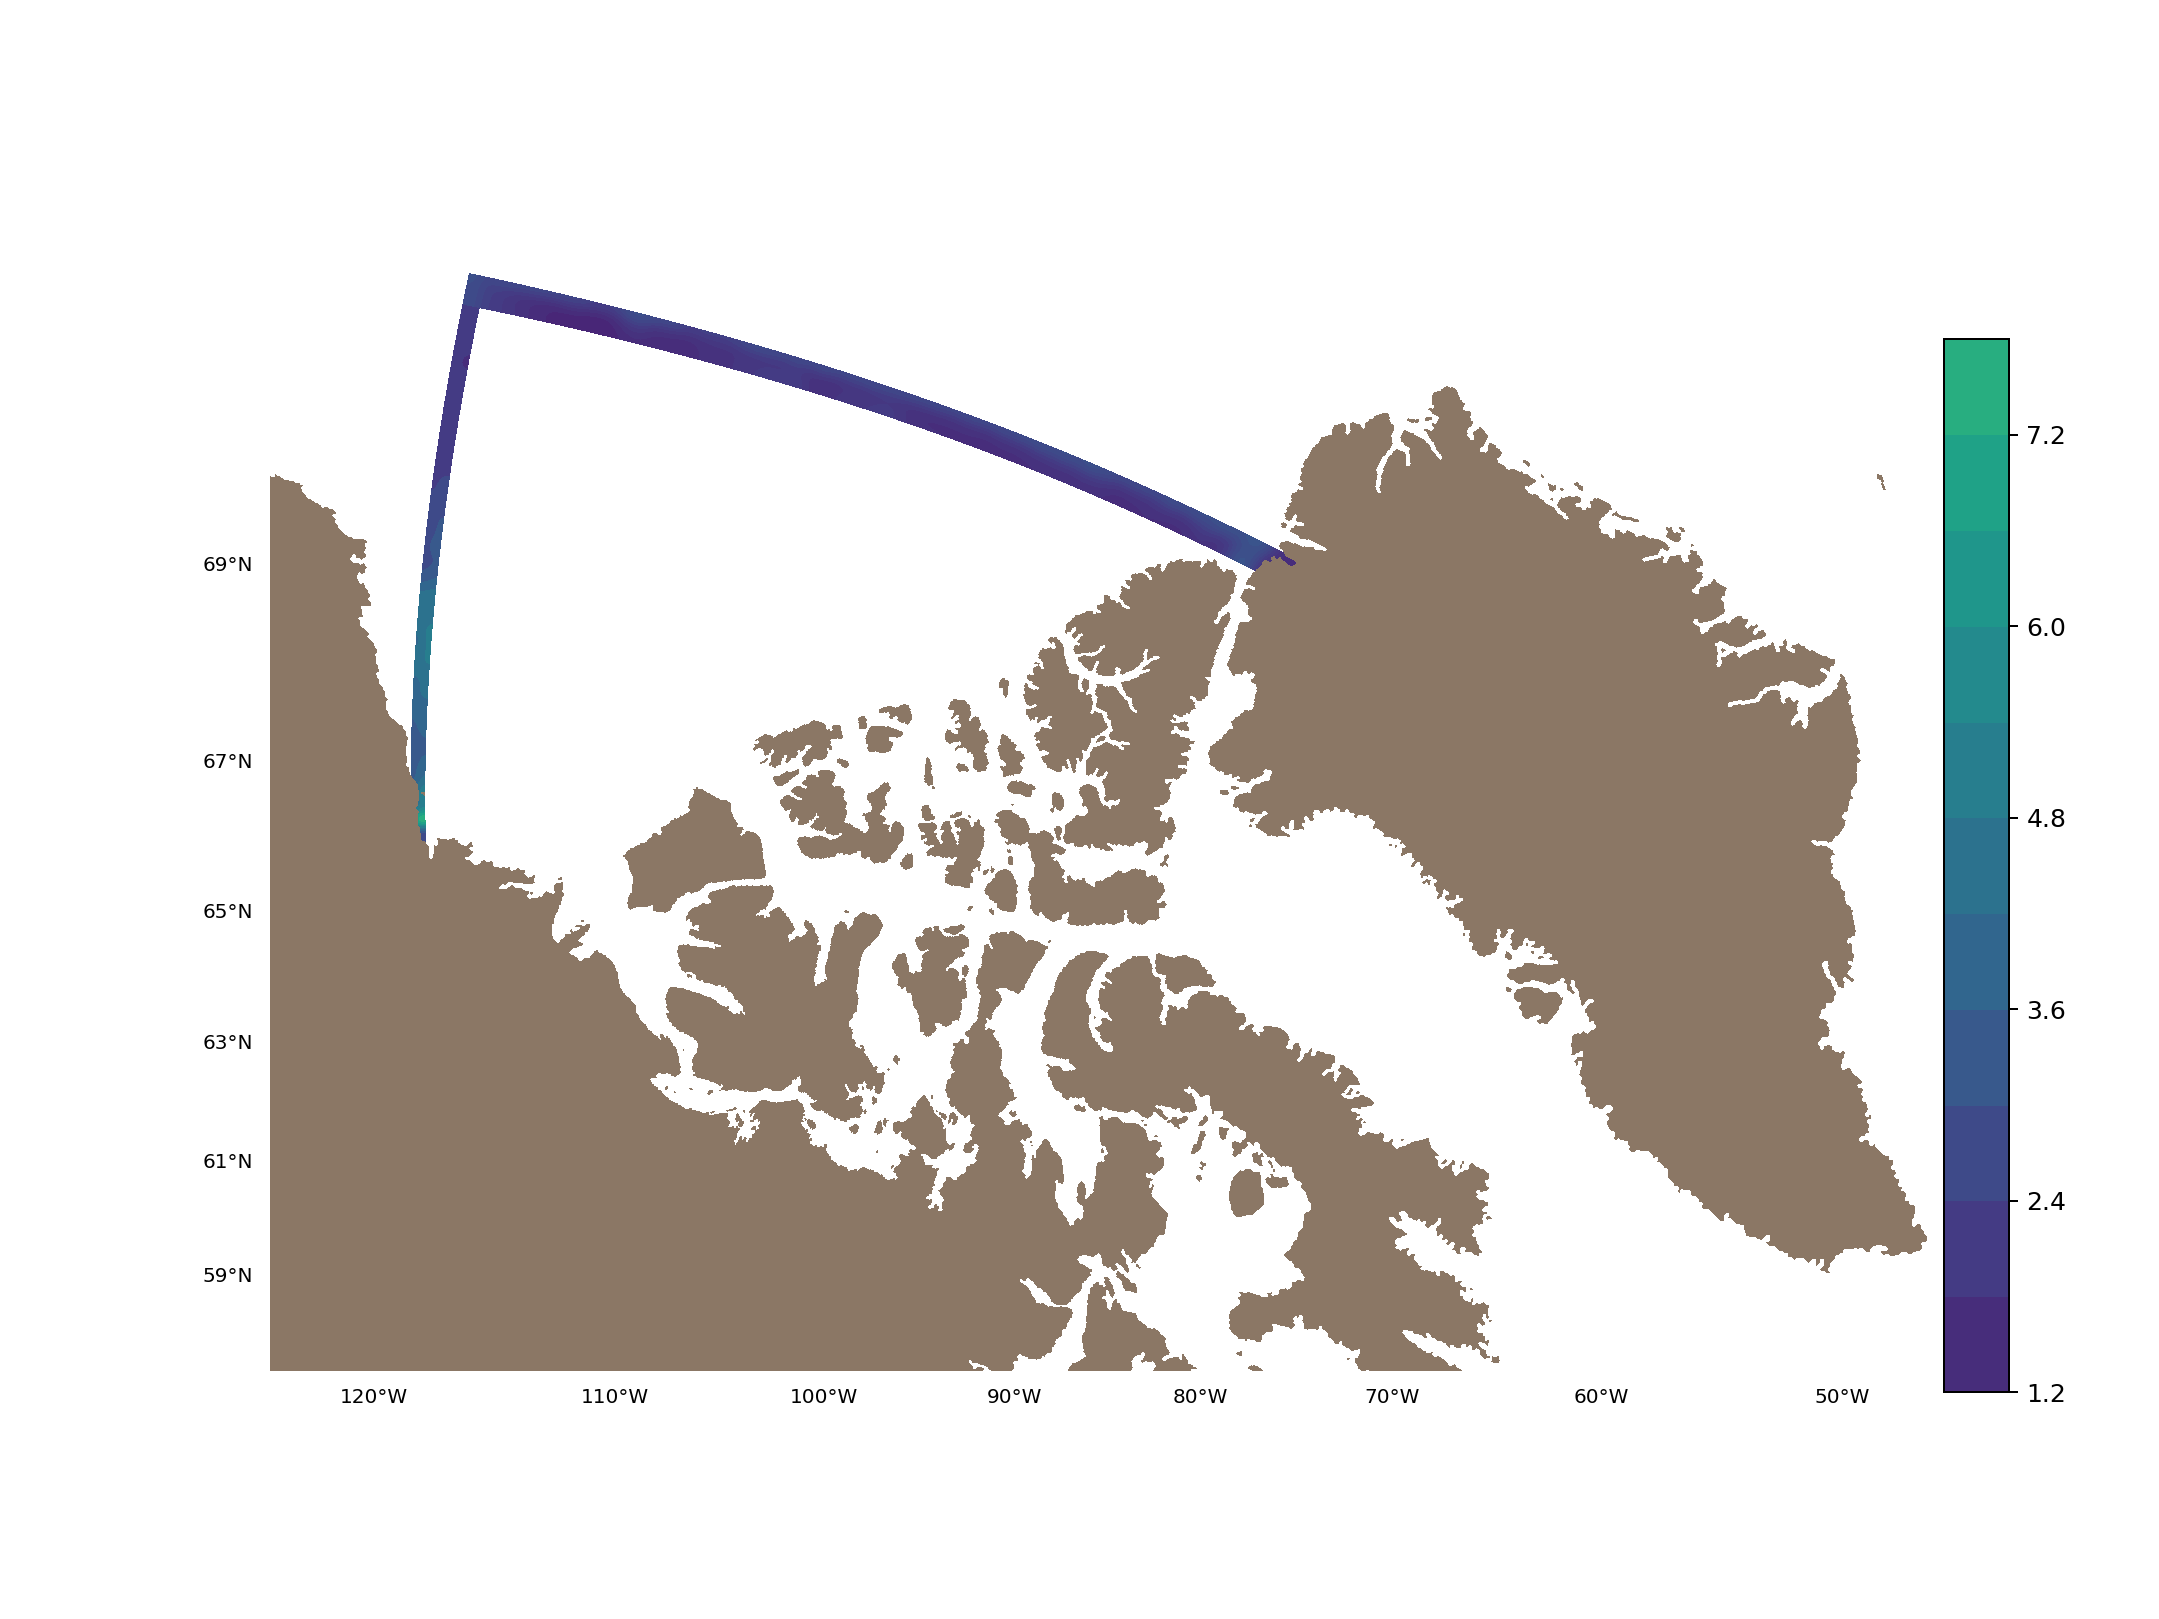

In [53]:
fig, ax1, proj1 = pickle.load(open('/ocean/brogalla/GEOTRACES/pickles/mn-reference.pickle','rb'))
#-----------------------------------------------------------------------------

xN, yN = proj1(lon_model[N_coordinates[0]:N_coordinates[1],N_coordinates[2]:N_coordinates[3]], \
               lat_model[N_coordinates[0]:N_coordinates[1],N_coordinates[2]:N_coordinates[3]])
xE, yE = proj1(lon_model[E_coordinates[0]:E_coordinates[1],E_coordinates[2]:E_coordinates[3]], \
               lat_model[E_coordinates[0]:E_coordinates[1],E_coordinates[2]:E_coordinates[3]])
CB1 = proj1.contourf(xN, yN, dMn_north[0,:,:]*10**9, 10, vmin=0, vmax=12)
CB2 = proj1.contourf(xE, yE, dMn_east[0,:,:]*10**9, 10, vmin=0, vmax=12)


cbaxes = fig.add_axes([0.90, 0.14, 0.03, 0.65]) 
CBar = plt.colorbar(CB1, ax=ax1, cax=cbaxes) 

#### Mask land areas with a low background concentration

In [84]:
dMn_north[(mbathy[:,N_coordinates[0]:N_coordinates[1],N_coordinates[2]:N_coordinates[3]] < 0.1)] = 0.2e-9
dMn_north[(mbathy[:,N_coordinates[0]:N_coordinates[1],N_coordinates[2]:N_coordinates[3]] < 0.1)] = 0.2e-9

In [85]:
dMn_east[(mbathy[:,E_coordinates[0]:E_coordinates[1],E_coordinates[2]:E_coordinates[3]] < 0.1)] = 0.2e-9
dMn_east[(mbathy[:,E_coordinates[0]:E_coordinates[1],E_coordinates[2]:E_coordinates[3]] < 0.1)] = 0.2e-9

#### Write final boundary condition:

In [86]:
dMn_north_BC, oMn_north_BC = create_boundary(rimwidth_north, dMn_north, oMn_north)
dMn_east_BC, oMn_east_BC   = create_boundary(rimwidth_east, dMn_east, oMn_east)

In [87]:
save_BC_file('Mn_North_OBC_20201215.nc', dMn_north_BC, oMn_north_BC)

In [88]:
save_BC_file('Mn_East_OBC_20201215.nc', dMn_east_BC, oMn_east_BC)